# A point analysis of weak learning models

    Notebook version: 1.3 (Jan 04, 2021)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Changes: v.1.0 - First version
             v.1.3 - Implements optimal reconstructions

In [3]:
# To visualize plots in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt

# Import some libraries that will be necessary for working with data
import numpy as np
from collections import Counter

# Local imports
import weaklabels.WLweakener as wlw


## 1. Introduction.

In this notebook we analyze the behavior of sample based estimates of a $C$-dimensional probability vector $\boldsymbol{\eta}$ from binary vector instances.

The main goal is to compare the behavior of a "supervised" estimate, based on a set of labels $\{{\bf y}_k, k=0,\ldots, K-1\}$ generated from $\boldsymbol{\eta}$, and estimates based on weak labels, $\{{\bf b}_k, k=0,\ldots, K-1\}$, generated from some related distribution ${\bf p} = {\bf M}\boldsymbol{\eta}$, where ${\bf M}$ is called a mixing matrix and contains conditional probabilities.

To do so, we will generate a dataset of labels drawn from $\boldsymbol{\eta}$, and one or more datasets of weak labels drawn from ${\bf p}$.

First we define some configurable parameters:

In [107]:
# CONFIGURABLE PARAMETERS FOR THE WHOLE NOTEBOOK
K = 100000                        # Sample size

# Number of classes
C = 3

# Parameters of the dirichlet model for eta
alpha_eta = 1  # 0.9   # sparse eta for alpha_eta -> 0, uniform form alpha_eta -> inf

# Weak Label model. Used to generate the mixing matrix.
# Available options are: supervised, noisy, random_noise, random_weak, IPL, IPL3, quasi-IPL
wl_model = 'random_weak'   # 'quasi-IPL'    # 'random_noise'   # 'noisy', 'quasi_IPL'

# Parameters of the weak label model
# Noise degree parameter [0, 1]. The higher alpha_M, the further from a clean label setting
alpha_M = 0.9
# Noise distribution parameter
beta_M = 0.9
beta_M = [10, 0.01, 0.01, 10, 0.01, 10, 10, 10]

# Virtual label model
# This is the model used to estimate the virtual label matrix (only for some of the notebook cells)
# Available options are: binary, quasi_IPL, M-pinv, M-conv, M-opt, M-opt_conv, ...
vl_model = 'M-pinv'

# Seed
np.random.seed(3)

### 1.1 Model

#### 1.1.1. Target probabilities

In the following, we will generate the target probability vector using a Dirichlet model. Alternativelly, you can assign a determistic probability vector (with size $C$).

In [108]:
# Stochastically generated probability vector...
#np.random.seed(500)
eta = np.random.dirichlet(alpha_eta * np.ones(C))
# eta = np.array([1,1,1])
# eta = eta / np.sum(eta)

# Probability vector
# eta = np.array([0.5, 0.2, 0.3])   # True probability vector
# eta = np.array([0.35, 0.3, 0.2, 0.1, 0.03, 0.02])   # True probability vector
# C = len(eta)   

print(f"Target probabilities: {eta}")


Target probabilities: [0.33688219 0.51840834 0.14470947]


#### 1.1.2. Mixing Matrix.

Based on the selected weak label model, we generate and visualize the corresponding mixing matrix.

Weak classes: [0 1 2 3 4 5 6 7]


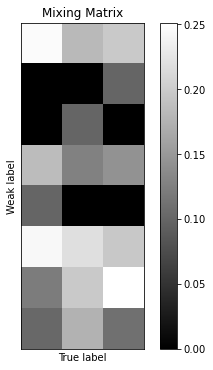

In [109]:
# Create a weak label model object
WLM = wlw.WLmodel(C, model_class=wl_model)

# Generate a mixing matrix
M = WLM.generateM(alpha=alpha_M, beta=beta_M)
n_weak = M.shape[0]      # Number of weak categories

# Remove weak classes with zero probability
WLM.remove_zero_rows()
M = WLM.M                # This is just to abbreviate
print(f"Weak classes: {WLM.weak_classes}")

# Show mixing matrix
if n_weak < 5:
    print("Mixing matrix:")
    print(M)
    print(f"Corresponding to weak label indices {dec_labels}")

plt.figure(figsize=(6, 6))
plt.imshow(M, interpolation='nearest', cmap="gray", clim=(0.0, np.max(M))) 
plt.colorbar()
plt.title('Mixing Matrix')
plt.xlabel('True label')
plt.ylabel('Weak label')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### 1.2. Weak label priors

In the following we analyze the sparsity of the weak label priors by showing the values of the prior weak label probabilities in increasing order.

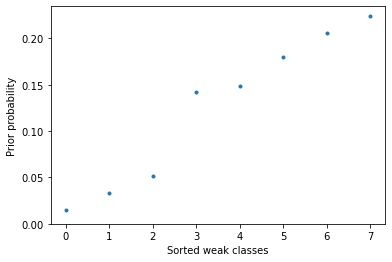

The normalized entropy (max 1) is) 0.893585886009969


In [110]:
# True priors
p = M @ eta

# Normalized entropy (in [0,1])
h = - p @ np.log(p).T / np.log(len(p))

plt.plot(np.sort(p),'.')
plt.ylim((0, plt.ylim()[1]))
plt.xlabel('Sorted weak classes')
plt.ylabel('Prior probability')
plt.show()

print(f'The normalized entropy (max 1) is) {h}')

### 1.3. Dataset generation.

In the following we will generate a dataset of labels and their corresponding weak labels

In [111]:
# Generate true labels
I = np.eye(C)
iy = np.random.choice(np.arange(0, C), size=K, p=eta)
y = I[iy]

# Generate weak label indices
z = WLM.generateWeak(iy)
print(z)

[5 5 6 ... 7 6 5]


### 1.4. Learning from clean labels.

In the supervised setting, ${\bf y}$ is observed an the optimal sample based estimate of $\boldsymbol{\eta}$ (minimizing any Bregman divergence) based on the observed labels is the sample average

In [112]:
# Probability estimation based on clean labels
f = np.mean(y, axis=0)
print(f"Supervised estimate: {f}")
e2 = np.sum((f - eta)**2)
print(f"Square error: {e2}")

Supervised estimate: [0.33638 0.51744 0.14618]
Square error: 3.352325099267507e-06


### 1.5. Learning from weak labels.

There are many ways to estimate $\boldsymbol{\eta}$ from the weak labels. We consider here a representative sample of them:

#### 1.5.1. Reconstruction Matrices

In the following we compute the reconstrution matrices based on left-inverses, using the true weak label priors and estimations based on data

In [113]:
# Compute different types of reconstruction matrices
Y_pinv = wlw.virtual_label_matrix(M, p=None, convex=False)
Y_conv = wlw.virtual_label_matrix(M, p=None, convex=True)
Y_opt = wlw.virtual_label_matrix(M, p=p, convex=False)
Y_opt_conv = wlw.virtual_label_matrix(M, p=p, convex=True)

# Compute estimated priors
z_count = Counter(z)
p_est = np.array([z_count[x] for x in WLM.weak_classes])
p_est = p_est / np.sum(p_est)
# Project prior on the mixing matrix subspace
p_est = M @ np.linalg.lstsq(M, p_est, rcond=None)[0]

# Compute reconstruction matrices based on estimated priors
Y_opt_est = wlw.virtual_label_matrix(M, p=p_est, convex=False)
Y_opt_conv_est = wlw.virtual_label_matrix(M, p=p_est, convex=True)

# Set
eta2 = eta.T @ eta
mse_pinv = (np.diag(Y_pinv.T @ Y_pinv) @ p - eta2)
mse_conv = (np.diag(Y_conv.T @ Y_conv) @ p - eta2)
mse_opt = (np.diag(Y_opt.T @ Y_opt) @ p - eta2)
mse_opt_conv = (np.diag(Y_opt_conv.T @ Y_opt_conv) @ p - eta2)

mse_opt_est = (np.diag(Y_opt_est.T @ Y_opt_est) @ p - eta2)
mse_opt_conv_est = (np.diag(Y_opt_conv_est.T @ Y_opt_conv_est) @ p - eta2)


In the following we visualize the MSE for each of the reconstruction matrices. The results may depend on different factors like the sample size, the true probability vector or the mixing matrix but, in general,

   * The MSE of the optimized reconstruction matrices (i.e. those using the prior weak label probabilities) is significantly smaller than the other methods: the pseudoinverse (${\bf M}_\text{pinv}$) and the reconstruction proposed by Van Royen et al (${\bf M}_\text{pinv}$).
   * The convexity constraint has a small impact.

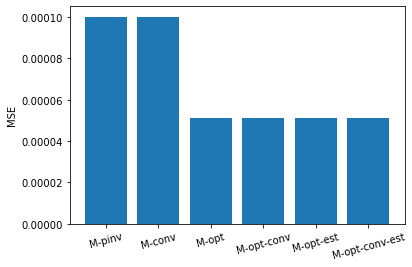

M-pinv: 10.011334369565052
M-conv: 9.978780753046085
M-opt: 5.103014621618695
M-opt-conv: 5.10301462160034
M-opt-est: 5.1037398312476405
M-opt-conv-est: 5.10373982684393


In [114]:
mse_th = {'M-pinv': mse_pinv / K, 'M-conv': mse_conv / K, 'M-opt': mse_opt / K,
          'M-opt-conv': mse_opt_conv / K, 'M-opt-est':  mse_opt_est / K,
          'M-opt-conv-est': mse_opt_conv_est / K}

plt.bar(mse_th.keys(), mse_th.values())
plt.xticks(range(len(mse_th)), mse_th, rotation='15')
plt.axis('tight')
plt.ylabel('MSE')
plt.show(block=False)

print(f"M-pinv: {mse_pinv}")
print(f"M-conv: {mse_conv}")
print(f"M-opt: {mse_opt}")
print(f"M-opt-conv: {mse_opt_conv}")
print(f"M-opt-est: {mse_opt_est}")
print(f"M-opt-conv-est: {mse_opt_conv_est}")


#### 1.5.2. Impact of the convexity constraint.

We compute here the Frobenius norm of the difference between the reconstruction matrices obtained with and without the convexity constraint. The smaller the value, the smaller the expected impact of the convexity constraint

In [115]:
ne = M.size
E_pinv = np.linalg.norm(Y_pinv - Y_conv, ord='fro') / ne 
E_opt = np.linalg.norm(Y_opt - Y_opt_conv, ord='fro') / ne

print(f"Impact of the convexity on the non-optimized reconstruction: {E_pinv}")
print(f"Impact of the convexity on the optimized reconstruction: {E_opt}")

Impact of the convexity on the non-optimized reconstruction: 0.03518781010881808
Impact of the convexity on the optimized reconstruction: 1.163190570419946e-06


#### 1.5.1. Averaging virtual labels

If ${\bf z}$ is a sample from distribution ${\bf p}$, and ${\bf V}$ is any left inverse of the mixing matrix (so that ${\bf V}{\bf M} = {\bf I}$ then it can be shown that $\mathbb{E}\{{\bf v}\} = \boldsymbol{\eta}$. Therefore, the sample average of virtual labels is an umbiased estimate of $\boldsymbol{\eta}$.

In [116]:
print(f"Computing virtual labels with method {vl_model}")
v = WLM.virtual_labels(z, vl_model, p=p)
print(f"Virtual labels are: {v}")
f_v = np.mean(v, axis=0)

print(f"Virtual label estimate: {f_v}")
e2 = np.sum((f_v - eta)**2)
print(f"Square error: {e2}")

Computing virtual labels with method M-pinv
Virtual labels are: [[ 1.33592033  0.82198836 -0.87328122]
 [ 1.33592033  0.82198836 -0.87328122]
 [-2.62337504  0.28665219  3.46728225]
 ...
 [-1.11116998  3.45339603 -1.52102201]
 [-2.62337504  0.28665219  3.46728225]
 [ 1.33592033  0.82198836 -0.87328122]]
Virtual label estimate: [0.33837125 0.52349601 0.13826389]
Square error: 6.964715690828727e-05


The choice of ${\bf V}$ is relevant. Different reconstruction matrices (i.e., left inverses of the mixing matrix) may have better behavior under finite samples.

#### 1.5.2. Maximum Likelihood Estimate

The expected value of a virtual label vector can be shown to be equal to the minimizer of the expected log likelihood. This implies that, on average, the average of the virtual label vector and the ML estimate should be assymptotically equivalent. However, for a finite sample size, they can also lead to different results.

The following function computes the ML estimate by means of the EM algorithm.

In [117]:
def computeML(iz, M, f0=None, max_iter=1e10, echo='off'):
    """
    Compute the ML estimate of a probability vector based on weak labels in iz
    and the mixing matrix M.
    The estimation method is based on Expectation-Maximization.
    
    Parameters
    ----------
    iz       :Observed weak labels
    M        :Mixing matrix
    f0       :Initial value of the ML estimate.
    max_iter :Maximum number of iterations.
    echo     :If 'on', output messages are shown

    Returns
    -------
    f_ml     :Maximum likelihood estimate
    """

    # Initialize the estimate.
    if f0 is None:
        C = M.shape[1]   # No. of classes
        f_ml = np.ones(C)/C
    else:
        f_ml = f0

    # Recursive estimation
    iterate = True
    count = 0
    while iterate:
        fi = np.dot(np.diag(f_ml), M.T)[:,iz.astype(int)]
        fi = fi / np.sum(fi, axis=0)
        f_new = np.mean(fi, axis=1)
        count += 1
        iterate = np.any(f_new != f_ml) and count < max_iter
        f_ml = np.copy(f_new)
    
    if echo=='on':
        if count>= max_iter:
            print(f"Stopped before convergence after {max_iter} iterations")
        else:
            print(f"Converged in {count} iterations")

    return f_ml

def computeNLL(iz, M, f):
    """
    Compute the Log-Likelihood function for an estimate f.
    """
    
    I = np.eye(M.shape[0])
    z = I[iz.astype(int)]
    NLL = - np.dot(np.mean(z, axis=0), np.log(np.dot(M, f)))

    return NLL

We can verify that the EM steps monotonically decrease the NLL

Converged in 199 iterations
Iteration 199 out of 200   eta = [0.33688219 0.51840834 0.14470947]
f_ml = [0.33396173 0.52430621 0.14173206]
f_v = [0.33837125 0.52349601 0.13826389]


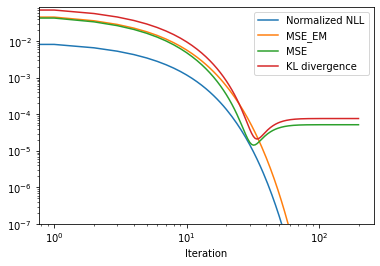

The final estimate is [0.33396173 0.52430621 0.14173206]
The true label is [0.33688219 0.51840834 0.14470947]


In [118]:
n_it = 200

# Compute inverted index 
z2i = dict(zip(WLM.weak_classes, range(len(WLM.weak_classes))))

# Transform (decimal) weak labels into their corresponding indices in dec_labels.
iz = np.array([z2i[zi] for zi in z])

# Compute weak label proportions
I = np.eye(M.shape[0])
B = I[iz]
q = np.mean(B, axis=0)

# Compute ML estimate based on iz and M
f_lim = computeML(iz, M, f, max_iter=10000, echo='on')

f = None
NLL, MSE, KL, MSE_EM = [], [], [], []

for i in range(n_it):
    print(f"\rIteration {i} out of {n_it}   ", end="")

    # Apply a single iteration of EM (max_iter=1) to see the evolution
    f_new = computeML(iz, M, f, max_iter=1)
    
    # If the EM has converged, we stop iterating
    if f is not None and np.all(f_new == f):
        break

    # Update EM estimate.
    f = np.copy(f_new)

    # NLL.append(computeNLL(iz, M, f) + np.dot(q, np.log(q)))
    NLL.append(computeNLL(iz, M, f) + q @ np.log(M @ f_lim))
    MSE.append(np.sum((f - eta)**2))
    KL.append(- eta @ np.log(f) + eta @ np.log(eta))
    MSE_EM.append(np.sum((f - f_lim)**2))

print(f"eta = {eta}")
print(f"f_ml = {f}")
print(f"f_v = {f_v}")
its = range(len(NLL))
plt.loglog(its, NLL, label= "Normalized NLL")
plt.loglog(its, MSE_EM, label= "MSE_EM")
plt.loglog(its, MSE, label= "MSE")
plt.loglog(its, KL, label= "KL divergence")
plt.legend(loc='best')
plt.axis('tight')
plt.xlabel('Iteration')
# plt.ylim((1e-7, plt.ylim()[1]))
plt.ylim((1e-7, max([max(MSE), max(KL), max(MSE_EM), max(NLL)])))
plt.show()
print(f"The final estimate is {f}")
print(f"The true label is {eta}")


In the figure above, we can expect that both the *Normalized NLL* and the *MSE_EM* converge to zero, because both measures are based on the comparison with the limit value. The curves are usefull to verify that the error measures decrease monotonically.

The *MSE* and the *KL divergence*, which are computed with respect to the true probability vector, $\boldsymbol{\eta}$, do not usually converge to zero, because, due to the finite sample size, the EM iterations does not converge exactly to $\boldsymbol{\eta}$, but to a close value, ${\bf f}_\text{lim}$. Yoy may check that the limit values of these error measures are smaller when the sample size increases.

In [119]:
f_ml = computeML(iz, M, max_iter=100000, echo='on')

print(f"ML estimate: {f_ml}")
e2 = np.sum((f_ml - eta)**2)
print(f"Square error: {e2}")

Converged in 231 iterations
ML estimate: [0.33396173 0.52430621 0.14173206]
Square error: 5.2179057246886284e-05


## 2. Statistical analysis of the MSE.

We will compute all estimates multiple times in order to compare the distribution of the MSE.

First, to make sure that the WLL estimate is working properly, we plot the convergence of the estimate with the number of iterations

In [120]:
n_sim = 100
mse = {'wll': []}
K = 1000
for n in range(n_sim):
 
    if (n+1)/1*1 == n+1:
        print(f'\r Simulation {n+1} out of {n_sim}', end="")
    # Generate true labels
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)

    # Generate weak label indices
    z = WLM.generateWeak(iy)

    # Estimation with virtual labels (M and dec_labels are not used if vl_model=='Mproper')
    v = WLM.virtual_labels(z, vl_model, p=p)
        
    f_v = np.cumsum(v, axis=0) / np.arange(1, K+1)[:,np.newaxis]
    mse_n = np.sum((f_v - eta)**2, axis=1)
    mse['wll'].append(mse_n)    

 Simulation 100 out of 100

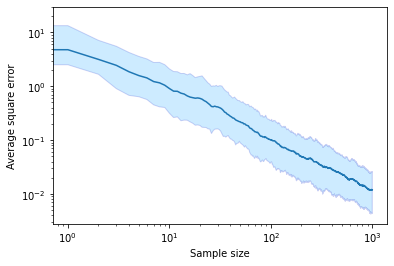

In [121]:
mse_mean = np.mean(mse['wll'], axis=0)
d = mse['wll'] - mse_mean
mse_std_u = np.sqrt(np.sum(d**2*(d >=0), axis=0)/np.sum((d >=0), axis=0))
mse_std_d = np.sqrt(np.sum(d**2*(d <=0), axis=0)/np.sum((d <=0), axis=0))
plt.fill_between(range(K), mse_mean - mse_std_d, mse_mean + mse_std_u,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=1, linestyle='solid', antialiased=True)
plt.loglog(range(K), mse_mean)
plt.axis('tight')
plt.xlabel('Sample size')
plt.ylabel('Average square error')
plt.show()

### 2.1. Supervision vs partial supervision

In the following we test, for a fixed sample size, the estimation of $\boldsymbol{\eta}$ as the average of virtual labels, in comparison with a complete supervision (i.e., as the average of the true labels).

In [122]:
K = 100
n_sim = 200
vl_models = ['M-pinv', 'M-conv', 'M-opt-conv', 'M-opt']
tag_list = vl_models + ['wml', 'sup']
# tag_list = ['sup', 'wml'] + vl_models
mse = {x: [] for x in tag_list}
mse2 = {x: [] for x in tag_list}

I_C = np.eye(C)
np.random.seed(3)

Y_pinv = wlw.virtual_label_matrix(M, p=None, convex=False)
Y_conv = wlw.virtual_label_matrix(M, p=None, convex=True)
Y_opt = wlw.virtual_label_matrix(M, p=p, convex=False)
Y_opt_conv = wlw.virtual_label_matrix(M, p=p, convex=True)
Y_all = {'M-pinv': Y_pinv, 'M-conv': Y_conv, 'M-opt': Y_opt, 'M-opt-conv': Y_opt_conv}

for n in range(n_sim):
 
    if (n+1)/1*1 == n+1:
        print(f'\r Simulation {n+1} out of {n_sim}', end=""),

    # Generate true labels
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I_C[iy]

    # Generate weak label indices
    z = WLM.generateWeak(iy)
    iz = np.array([z2i[zi] for zi in z])

    # Supervised estimation
    f = np.mean(y, axis=0)
    mse['sup'].append(np.sum((f - eta)**2))

    # Estimation with ML-EM
    f_ml = computeML(iz, M, f0=None, max_iter=1000, echo='off')
    mse['wml'].append(np.sum((f_ml - eta)**2))

    p_reg = WLM.estimate_wl_priors(z)

    # In some cases, cvxpy raises an error "problem does not follow dcp rules". To avoid this, 
    # regularizing by some small eps may help though it may distort the results
    # eps = 0.005
    # p_reg = (p_reg + eps) / np.sum(p_reg + eps)
    
    for vl_model in vl_models:
        # Estimation with virtual labels
        # v = WLM.virtual_labels(z, method=vl_model, M=M, p=p)

        if vl_model == 'M-pinv':
            v = WLM.virtual_labels_from_Y(z, Y_pinv)
        elif vl_model == 'M-conv':
            v = WLM.virtual_labels_from_Y(z, Y_conv)
        elif vl_model == 'M-opt':
            Y = wlw.virtual_label_matrix(M, p_reg, convex=False)
            v = WLM.virtual_labels_from_Y(z, Y)
        elif vl_model == 'M-opt-conv':
            Y = wlw.virtual_label_matrix(M, p_reg, convex=True)
            v = WLM.virtual_labels_from_Y(z, Y)

        f_v = np.mean(v, axis=0)
        mse[vl_model].append(np.sum((f_v - eta)**2))

mse_emp = [np.mean(mse[x]) for x in tag_list]
print(vl_models)
print(mse_emp[2:])

 Simulation 200 out of 200['M-pinv', 'M-conv', 'M-opt-conv', 'M-opt']
[0.04805347795787904, 0.048053389930264735, 0.04805308534811859, 0.005996048202124813]


In [123]:
print(f"Estimated weak label priors: {p_reg}")

Estimated weak label priors: [2.20676251e-01 1.70902018e-09 4.01860783e-02 1.61257992e-01
 5.98139195e-02 2.33817278e-01 1.52178002e-01 1.32070473e-01]


The following error plots shows the performance degradation caused by the use of weak labels. Under very weak supervision, there is a significant degradation.

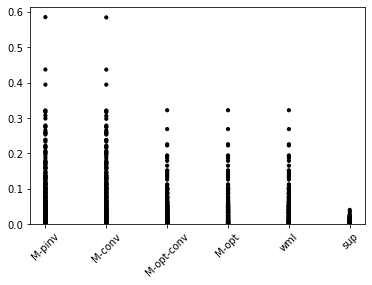

In [124]:
for i, tag in enumerate(tag_list):
    plt.scatter([i + 1]*n_sim, mse[tag], c=[i]*n_sim, s=10, cmap='copper')
plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
plt.axis('tight')
plt.ylim((0, plt.ylim()[1]))
plt.show(block=False)

#for i, tag in enumerate(tag_list):
#     plt.bar([i + 1]*n_sim, np.mean(mse[tag]))
# plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
# plt.axis('tight')
# plt.ylim((0, plt.ylim()[1]))
# plt.show(block=False)

# plt.boxplot([mse[tag] for tag in tag_list])
# plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
# plt.show()

[0.10011334369565052, 0.09978780753046085, 0.0510301462160034, 0.05103014621618695, nan, nan]


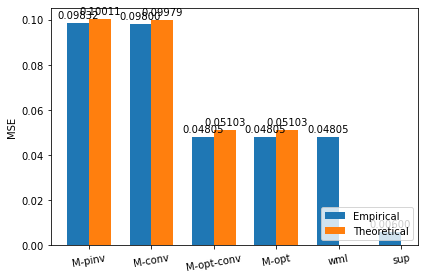

In [125]:
mse_emp = [np.mean(mse[x]) for x in tag_list]
mse_th = {'M-pinv': mse_pinv / K, 'M-conv': mse_conv / K, 'M-opt': mse_opt / K,
          'M-opt-conv': mse_opt_conv / K, 'M-opt-est':  mse_opt_est / K,
          'M-opt-conv-est': mse_opt_conv_est / K}

for x in tag_list:
    if x not in mse_th:
        mse_th[x] = np.nan
mse_th2 = [mse_th[x] for x in tag_list ]
print(mse_th2)

x = np.arange(len(tag_list))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse_emp, width, label='Empirical')
rects2 = ax.bar(x + width/2, mse_th2, width, label='Theoretical')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_xticks(x)
ax.set_xticklabels(tag_list, rotation='10')
ax.legend(loc='lower right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.5f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom')

#ax.set_ylim((0, 1.2 * max(np.max(mse_emp), np.max(mse_th2))))
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()